# This notebook is for data loading and pre-processing of CelebA images using MTCNN Library

The First Step is to import all the required libraries which will be used for data loading, preprocessing and saving. 

In [1]:
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
import pandas as pd
import numpy as np

Using TensorFlow backend.


First, we set precision of output results to 3 and all enable the suppression of output prints for less verbose output. We will declare the names of all the attributes present in the CelebA dataset. We will read the attributes file of CelebA dataset which is saved in CSV format. We will then select only the Attractive column and covert it to numpy as we want to convert 50000 images classified as attractive. This is because source material is very important and it greatly affects the performance of the model. 
It is easy to miss a critical factor - what does the transformed data going into the cGAN look like. When the data going into a stream is a derivative of another process, as in this case, it is critical to examine the quality of the input data before declaring the results to be useful or invalid.
The code to examine the data going into the cGAN is trivial and is included in the final stream. It's worth remembering that the GAN process sees the images at the convoluted pixel level - it sees every spot and wrinkle, every imperfection.

In [2]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
varNames = ["image_id","5_o_Clock_Shadow","Arched_Eyebrows","Attractive","Bags_Under_Eyes","Bald","Bangs","Big_Lips",
            "Big_Nose","Black_Hair","Blond_Hair","Blurry","Brown_Hair","Bushy_Eyebrows","Chubby","Double_Chin","Eyeglasses",
            "Goatee","Gray_Hair","Heavy_Makeup","High_Cheekbones","Male","Mouth_Slightly_Open","Mustache","Narrow_Eyes",
            "No_Beard","Oval_Face","Pale_Skin","Pointy_Nose","Receding_Hairline","Rosy_Cheeks","Sideburns","Smiling",
            "Straight_Hair","Wavy_Hair","Wearing_Earrings","Wearing_Hat","Wearing_Lipstick","Wearing_Necklace",
            "Wearing_Necktie","Young"]
data_attractive = pd.read_csv('celebA\list_attr_celeba.csv', nrows=None)['Attractive'].to_numpy()

The next step is to develop code to load the images. We can use the Pillow library to load a given image file, convert it to RGB format (if needed) and return an array of pixel data. The load image() function below implements this.

In [3]:
# load an image as an rgb numpy array
def load_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    return pixels

Next, we can enumerate the directory of images, load each as an array of pixels in turn, and return an array with all of the images. There are 200K images in the dataset, which is probably more than we need so we can also limit the number of images to load with an argument. The load faces() function below implements this.
The other worth mentioning that this function does is that it extracts the filename of the images and then uses this filename to filter rows of the attribute file so that it uses the attributes of specific images.

In [11]:
# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
    # prepare model
    model = MTCNN()
    faces = list()
    ids = list()
    # enumerate files
    for idx, filename in enumerate(listdir(directory)):
        # load the image
        pixels = load_image(directory + filename)
        # get face
        face = extract_face(model, pixels)
        if face is None:
            continue
        if data_attractive[idx] == -1.0:
            continue
        # store
        faces.append(face)
        ids.append(idx)
        if len(faces)%1000==0:
            print(len(faces), face.shape)
            print(idx)
        # stop once we have enough
        if len(faces) >= n_faces:
            break
    return asarray(faces),asarray(ids)

When working with a GAN, it is easier to model a dataset if all of the images are small and square in shape. Further, as we are only interested in the face in each photo, and not the background, we can perform face detection and extract only the face before resizing the result to a fixed size. There are many ways to perform face detection. In this case, we will use a pre-trained Multi-Task Cascaded Convolutional Neural Network, or MTCNN. This is a state-of-the-art deep learning model for face detection, described in the 2016 paper titled Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks. We will use the implementation provided by Ivan de Paz Centeno in the ipazc/mtcnn project.
The MTCNN model is very easy to use. First, an instance of the MTCNN model is created,then the detect faces() function can be called passing in the pixel data for one image. The result is a list of detected faces, with a bounding box defined in pixel offset values.
We can update our example to extract the face from each loaded photo and resize the extracted face pixels to a fixed size. In this case, we will use the square shape of 64x64 pixels. The extract face() function below implements this, taking the MTCNN model and pixel values for a single photograph as arguments and returning an 64x64 × 3 array of pixel values with just the face, or None if no face was detected (which can happen rarely).
We will be making two data set for our modelling. 
1: The set of images containing only the faces 
2: The set of images containing face along with background. 

In [12]:
# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(64, 64)):
    # detect face in the image
    faces = model.detect_faces(pixels)
    # skip cases where we could not detect a face
    if len(faces) == 0:
        return None
    # extract details of the face
    x1, y1, width, height = faces[0]['box']
    # force detected pixel values to be positive (bug fix)
    x1, y1 = abs(x1), abs(y1)
    # convert into coordinates
#     x2, y2 = int(x1 + (width*1.2)), int(y1 + (height*1.2))
#     if (x1 -width/4) < 0:
#         x1 = 0
#     else:
#         x1 = int(x1 - width/4)
#     if (y1 - height/2) < 0:
#         y1 = 0
#     else:
#         y1 = int(y1 - height/2)
    # extract details of the face
    x1, y1, width, height = faces[0]['box']
    # force detected pixel values to be positive (bug fix)
    x1, y1 = abs(x1), abs(y1)
    # convert into coordinates
    x2, y2 = x1 + width, y1 + height
    # retrieve face pixels
    face_pixels = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

Then, we spectify the directory of images and saves the required preprocessed images and their ids in compressed npz form.

In [ ]:
# directory that contains all images
directory = 'celebA/img_align_celeba/img_align_celeba/'
# load and extract all faces
n_faces = 50000
all_faces, all_ids = load_faces(directory, n_faces)
print('Loaded faces: ', all_faces.shape)
print('Loaded ids: ', all_ids.shape)
qSave = True
if qSave:
    savez_compressed('celebA/img_align_celeba_attractive_face.npz', all_faces)
    savez_compressed('celebA/ids_align_celeba_attractive_face.npz', all_ids)


We can then display some of the images that we have stored as compressed npz files and verify our dataset.

(50000, 64, 64, 3)
50000


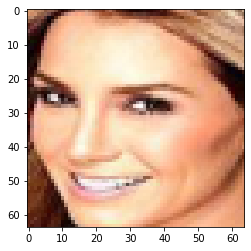

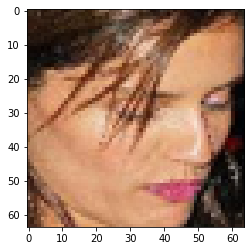

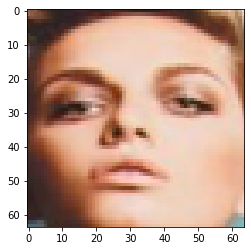

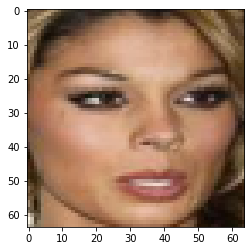

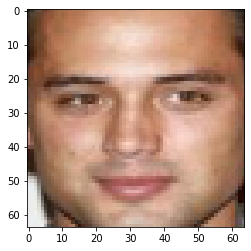

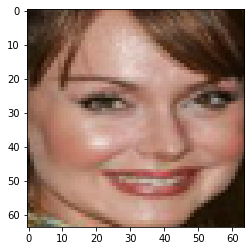

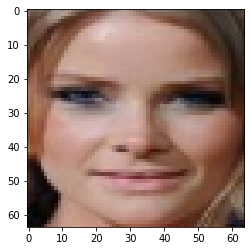

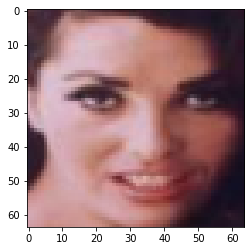

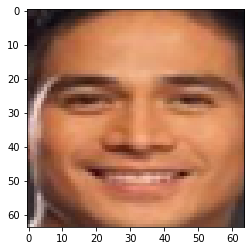

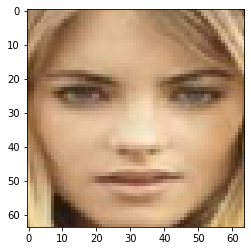

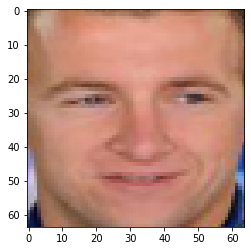

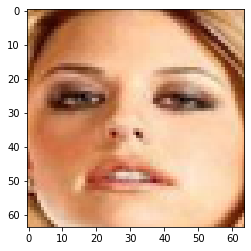

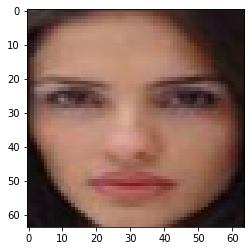

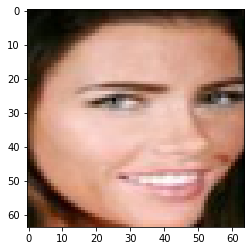

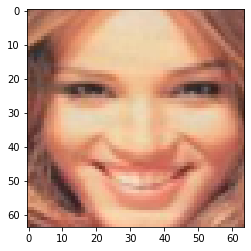

In [14]:
dfile = "celebA/img_align_celeba_attractive_face.npz"
images = np.load(dfile)["arr_0"]
print(images.shape)
lst = len(images)
print(lst)
for item in range(0,15):
    pyplot.ion()
    pyplot.figure()
    pyplot.imshow(images[item])